In [1]:
# install
!pip install -q d3blocks

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np

import os 
from matplotlib.pyplot import figure
import anndata
from scipy.spatial.distance import cdist, squareform, pdist
from scipy.stats import ks_2samp
from scipy.stats import pearsonr
import omnipath
%matplotlib inline

# Dataset 1: Mouse brain dataset

In [6]:
intercell = pd.read_csv("../../data/LR_database/intercell_Omnipath.csv")

In [7]:
consensus = pd.read_csv("../../data/LR_database/consensus_Omnipath.csv")

In [8]:
input_data=pd.read_csv("../../results/GraphComm_Output/Mouse/CCI.csv")

In [9]:
truth = pd.read_csv("../../data/raw_data/Mouse/truth_interactions.csv")[["Ligand","Receptor"]]

In [10]:
truth["Ligand"] = [i.upper() for i in truth["Ligand"].tolist()]
truth["Receptor"] = [i.upper() for i in truth["Receptor"].tolist()]

In [11]:
input_data = input_data[input_data["Src"].isin(intercell["source_genesymbol"])]

In [12]:
input_data = input_data[input_data["Dst"].isin(intercell["target_genesymbol"])]

In [13]:
total_nodes = pd.read_csv("../../data/GraphComm_Input/Mouse/nodes.csv")

In [14]:
input_data=pd.read_csv("../../results/GraphComm_Output/Mouse/CCI.csv")

In [15]:
input_data = pd.merge(input_data,truth,left_on=["Src","Dst"],right_on=["Ligand","Receptor"])

## make chord plot

In [16]:
grouped=input_data

In [17]:
ITGB1_grouped = grouped[grouped["Receptor"]=="ITGB1"]

In [18]:
ITGB1_grouped["Prob"]=(ITGB1_grouped["Prob"]-np.min(ITGB1_grouped["Prob"]))/(np.max(ITGB1_grouped["Prob"])-np.min(ITGB1_grouped["Prob"]))


<ipython-input-18-8f72a3ed2e59>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ITGB1_grouped["Prob"]=(ITGB1_grouped["Prob"]-np.min(ITGB1_grouped["Prob"]))/(np.max(ITGB1_grouped["Prob"])-np.min(ITGB1_grouped["Prob"]))


In [19]:
ITGB1_grouped = ITGB1_grouped.head(10)
ITGB1_grouped["Prob"] = ITGB1_grouped["Prob"] * 100

In [20]:
ITGB1_grouped = ITGB1_grouped[["Src","Dst","Prob"]]


In [21]:
df = pd.DataFrame(data=np.c_[ITGB1_grouped["Src"].tolist(), ITGB1_grouped["Dst"].tolist(), ITGB1_grouped["Prob"].tolist()], columns=['source','target','weight'])


In [24]:
from d3blocks import D3Blocks    
# Initialize
d3 = D3Blocks(chart='Chord')
d3.chord(df, color='source', opacity='source', cmap='Set2',filepath="/results/chord.html")

[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Chord]
[d3blocks] >INFO> filepath is set to [/tmp/d3blocks/chord.html]
[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Initializing [Chord]
[d3blocks] >INFO> filepath is set to [/results/chord.html]
[d3blocks] >INFO> Convert to DataFrame.
[d3blocks] >INFO> Node properties are set.
[d3blocks] >INFO> Set edge-opacity based on the [source] node-opacity.
[d3blocks] >INFO> Set edge-colors based on the [source] node-color.
[d3blocks] >INFO> Edge properties are set.
[d3blocks] >INFO> Open browser: /results/chord.html


In [25]:
%matplotlib inline
d3.show()

[d3blocks] >INFO> File already exists and will be overwritten: [/results/chord.html]
[d3blocks] >INFO> Open browser: /results/chord.html


## Measuring coverage of ligands and receptors

In [26]:
input_data=pd.read_csv("../../results/GraphComm_Output/Mouse/CCI.csv")

In [27]:
input_data = input_data[input_data["Src"].isin(intercell["source_genesymbol"])]

In [28]:
input_data = input_data[input_data["Dst"].isin(intercell["target_genesymbol"])]

In [29]:
input_data = input_data.head(100)

In [30]:
input_data.index = range(0,input_data.shape[0])

In [31]:
total_ligands = total_nodes[total_nodes["category"]=="Ligand"]["identifier"].unique().tolist()
total_receptors = total_nodes[total_nodes["category"]=="Receptor"]["identifier"].unique().tolist()

In [32]:
total_ligands = [i.split("_")[0] for i in total_ligands]
total_receptors = [i.split("_")[0] for i in total_receptors]

In [33]:
total_ligands = [i for i in total_ligands if i in intercell["source_genesymbol"].tolist()]
total_receptors = [i for i in total_receptors if i in intercell["target_genesymbol"].tolist()]

In [34]:
truth_total_ligands = [i for i in truth["Ligand"].unique().tolist() if i not in total_ligands]
truth_total_receptors = [i for i in truth["Receptor"].unique().tolist() if i not in total_receptors]

In [35]:
matrix = pd.read_csv("../../data/GraphComm_Input/Mouse/matrix.csv",index_col=0)

In [36]:
ligands = [i for i in truth["Ligand"].unique().tolist() if i in matrix.index.tolist()]
receptors = [i for i in truth["Receptor"].unique().tolist() if i in matrix.index.tolist()]

In [37]:
intersect_total_ligands = list(set(ligands)&set(truth_total_ligands))
intersect_total_receptors = list(set(receptors)&set(truth_total_receptors))

In [38]:
i = 0 
random_list = []
while i < 100:
    random_list.append(pd.read_csv(f"/data/random_data/Mouse/final_Mouse_{i}_random.csv"))
    i+=1

In [39]:
random_list = [i.head(100) for i in random_list]

In [40]:
total_random = pd.concat(random_list)

In [41]:
random_dfs = random_list

In [42]:
important_ligands = truth["Ligand"].unique().tolist()
important_receptors = truth["Receptor"].unique().tolist()

In [43]:
graphcomm_LR_list = []
for i in range(5,101,5):
    temp= input_data.head(i)
    ligands=[1 if i in important_ligands else 0 for i in temp["Src"].tolist()]
    receptors=[1 if i in important_receptors else 0 for i in temp["Dst"].tolist()]
    graphcomm_LR_list.append((np.sum(ligands)+np.sum(receptors))/(i*2))
random_LR_list = []
for i in random_dfs:
    sub_random = i
    sub_random_list = []
    for j in range(5,101,5):
        temp= sub_random.head(j)
        ligands=[1 if i in important_ligands else 0 for i in temp["Src"].tolist()]
        receptors=[1 if i in important_receptors else 0 for i in temp["Dst"].tolist()]
        sub_random_list.append((np.sum(ligands)+np.sum(receptors))/(j*2))
    random_LR_list.append(sub_random_list)

In [44]:
mean_random_LR_list = list(np.mean(random_LR_list,axis=0))

In [45]:
graphcomm_LR_list = [0] + graphcomm_LR_list
mean_random_LR_list = [0] + mean_random_LR_list

Text(0, 0.5, 'Fraction of interactions containing relevant ligands/receptors')

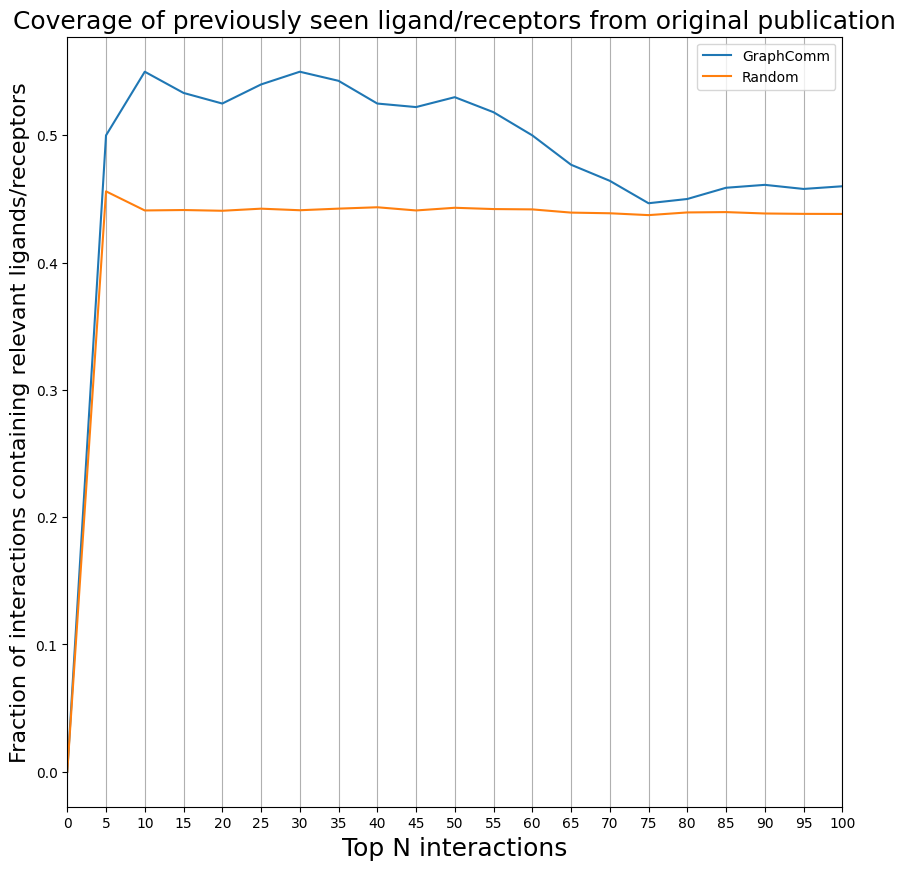

In [46]:
figure(figsize=(10,10))

plt.plot(range(0,101,5),graphcomm_LR_list,label="GraphComm")
plt.plot(range(0,101,5),mean_random_LR_list,label="Random")
plt.grid(axis = 'x')
plt.xticks(range(0,101,5))
plt.xlim((0,100))
#plt.ylim((0,10))
plt.legend()
plt.title("Coverage of previously seen ligand/receptors from original publication",fontdict={'fontsize':18})
plt.xlabel("Top N interactions",fontdict={'fontsize':18})
plt.ylabel("Fraction of interactions containing relevant ligands/receptors",fontdict={'fontsize':16})
#plt.savefig("/results/cdf.png")

# Dataset 3:scRNA PC9 cell line dataset with drug treatment - change comparison datasets to generate pre/post or biological replicate overlap (Figure 5)

### load datasets

In [47]:
day0=pd.read_csv("../../results/GraphComm_Output/Pre_Post/Day0/CCI.csv",index_col=0)
day7_rep1=pd.read_csv("../../results/GraphComm_Output/Pre_Post/Day7_1/CCI.csv",index_col=0)
day7_rep2=pd.read_csv("../../results/GraphComm_Output/Pre_Post/Day7_2/CCI.csv",index_col=0)

In [48]:
Omnipath_database = pd.read_csv("../../data/LR_database/intercell_Omnipath.csv",index_col=0)

In [49]:
Omnipath_database.columns = ["from","to","sources"]


### only retain, within each dataset, **validated intercell interactions from Omnipath**

In [50]:
day0=pd.merge(day0,Omnipath_database,left_on=["Src","Dst"],right_on=["from","to"])[["Src","Dst"]].drop_duplicates()
day7_rep1=pd.merge(day7_rep1,Omnipath_database,left_on=["Src","Dst"],right_on=["from","to"])[["Src","Dst"]].drop_duplicates()
day7_rep2=pd.merge(day7_rep2,Omnipath_database,left_on=["Src","Dst"],right_on=["from","to"])[["Src","Dst"]].drop_duplicates()

### find the number of common interactions within the top 100 between biological replicates (and save that value for the randomization experiment)

In [51]:
only_day7_1_ligands = day7_rep1[(~day7_rep1["Src"].isin(day0["Src"].tolist())) & (day7_rep1["Src"].isin(day7_rep2["Src"].tolist()))]
only_day7_1_receptors = day7_rep1[(~day7_rep1["Dst"].isin(day0["Dst"].tolist())) & (day7_rep1["Dst"].isin(day7_rep2["Dst"].tolist()))]

In [52]:
common = pd.merge(day7_rep1.head(100),day7_rep2.head(100))

In [53]:
original_accuracy = common.shape[0]/100

### use a stacked bar plot to visualize the commonalities

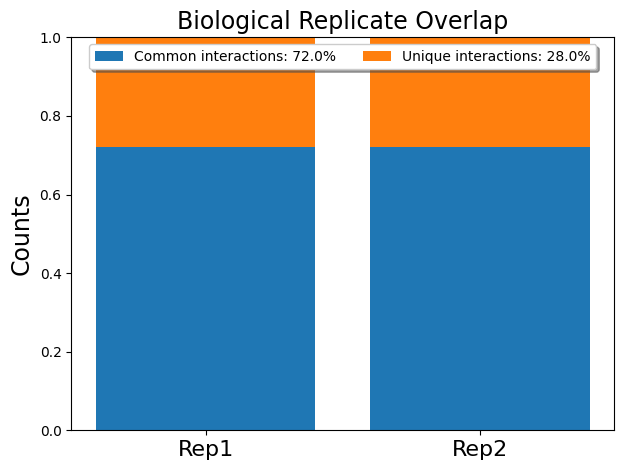

In [54]:
%matplotlib inline
labels = ["Rep1","Rep2"]
men_means = [round(common.shape[0]/100,3),round(common.shape[0]/100,3)]
women_means = [1- round(common.shape[0]/100,3),1- round(common.shape[0]/100,3)]
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()
ax.grid(False)

ax.bar(labels, men_means, label=f"Common interactions: {round(common.shape[0]/100*100,2)}%")
ax.bar(labels, women_means, bottom=men_means,
       label=f"Unique interactions: {round(100-round(common.shape[0]/100*100,3),2)}%")

ax.set_ylabel("Counts",fontsize=17)
ax.set_title("Biological Replicate Overlap",fontdict={"fontsize":17})
plt.xticks(fontsize=16)
ax.set_ylim((0,1))
ax.legend(loc='upper center',
          ncol=3, fancybox=True, shadow=True,fontsize=10)
plt.tight_layout()
#plt.savefig("/results/bio_rep.png")
plt.show()


### find the number of common interactions within the top 100 between pre and post treatment datasets (and save that value for the randomization experiment)

In [55]:
pre_post_common = pd.merge(day0.head(100),day7_rep2.head(100))

### use a stacked bar plot to visualize the commonalities

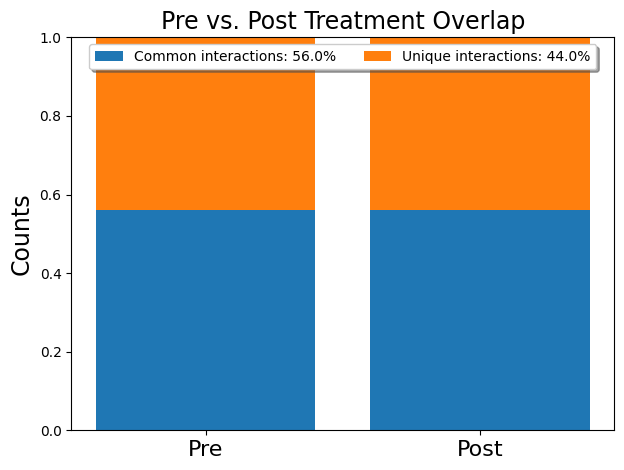

In [56]:
%matplotlib inline
labels = ["Pre","Post"]
men_means = [round(pre_post_common.shape[0]/100,3),round(pre_post_common.shape[0]/100,3)]
women_means = [1- round(pre_post_common.shape[0]/100,3),1- round(pre_post_common.shape[0]/100,3)]
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

ax.bar(labels, men_means, label=f"Common interactions: {round(pre_post_common.shape[0]/100*100,3)}%")
ax.bar(labels, women_means, bottom=men_means,
       label=f"Unique interactions: {round(100-round(pre_post_common.shape[0]/100*100,3),2)}%")

ax.set_ylabel("Counts",fontsize=17)
ax.set_title("Pre vs. Post Treatment Overlap",fontdict={"fontsize":17})
plt.xticks(fontsize=16)

ax.set_ylim((0,1))
ax.legend(loc='upper center',
          ncol=3, fancybox=True, shadow=True)
plt.tight_layout()
#plt.savefig("/results/bio_rep.png")
plt.show()


In [57]:
difference_accuracy = original_accuracy - pre_post_common.shape[0]/100

In [58]:
df = pd.merge(common, pre_post_common, on=['Src','Dst'], how='left', indicator='Exist')

## Compare difference between overlap biological replicates vs. pre and post for Original Set and 100 Randomized Interactions

### load the datasets

In [59]:
rep1_list = []
rep2_list = []
day_0_list = []
for i in range(0,100):
    day_0_list.append(pd.read_csv(f"../../data/random_data/Pre_Post/final_Day0_{i+1}_random.csv",index_col=0)[["Src","Dst"]])
    rep1_list.append(pd.read_csv(f"../../data/random_data/Pre_Post/final_Rep1_{i+1}_random.csv",index_col=0)[["Src","Dst"]])
    rep2_list.append(pd.read_csv(f"../../data/random_data/Pre_Post/final_Rep2_{i+1}_random.csv",index_col=0)[["Src","Dst"]])

In [60]:
Omnipath_database = pd.read_csv("../../data/LR_database/intercell_Omnipath.csv",index_col=0)[["source_genesymbol","target_genesymbol"]].drop_duplicates()
Omnipath_database.columns = ["from","to"]

#### within each randomized Rep1 and Rep2, subset for validated intercell interactions

In [61]:
day_0_list = [pd.merge(i,Omnipath_database,left_on=["Src","Dst"],right_on=["from","to"]) for i in day_0_list]

In [62]:
rep1_list = [pd.merge(i,Omnipath_database,left_on=["Src","Dst"],right_on=["from","to"]) for i in rep1_list]

In [63]:
rep2_list = [pd.merge(i,Omnipath_database,left_on=["Src","Dst"],right_on=["from","to"]) for i in rep2_list]

In [64]:
day_0_list = [i[["Src","Dst"]] for i in day_0_list]
rep1_list = [i[["Src","Dst"]] for i in rep1_list]
rep2_list = [i[["Src","Dst"]] for i in rep2_list]

In [65]:
rep_merged_list = [pd.merge(i.head(100),j.head(100)) for i,j in zip(rep1_list,rep2_list)]

In [66]:
pre_post_merged_list = [pd.merge(i.head(100),j.head(100)) for i,j in zip(day_0_list,rep2_list)]

### find the difference in overlap between each biological replicates and pre and post treatment

In [67]:
difference_list = [abs((i.shape[0]/100) - (j.shape[0]/100)) for i,j in zip(rep_merged_list,pre_post_merged_list)]

Text(0, 0.5, 'Count')

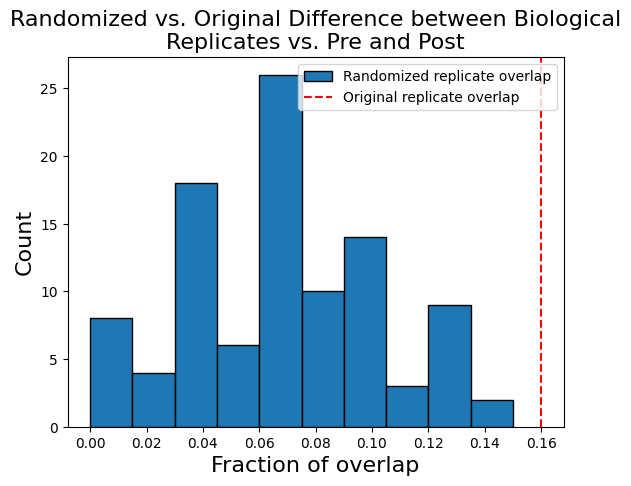

In [68]:
plt.hist(difference_list,edgecolor='black',rwidth=1,label="Randomized replicate overlap")
plt.axvline(difference_accuracy,linestyle="--",color="red",label="Original replicate overlap")
plt.title("Randomized vs. Original Difference between Biological\nReplicates vs. Pre and Post",fontdict={'fontsize':16})
plt.legend(loc="upper right")
plt.xlabel("Fraction of overlap",fontsize=16)
plt.ylabel("Count",fontsize=16)


## Compare overlap between biological replicates for Original Set and 100 Randomized Interactions

### find the fraction of overlap between each set of replicates

In [69]:
accuracy_list = [i.shape[0]/100 for i in rep_merged_list]

Text(0, 0.5, 'Count')

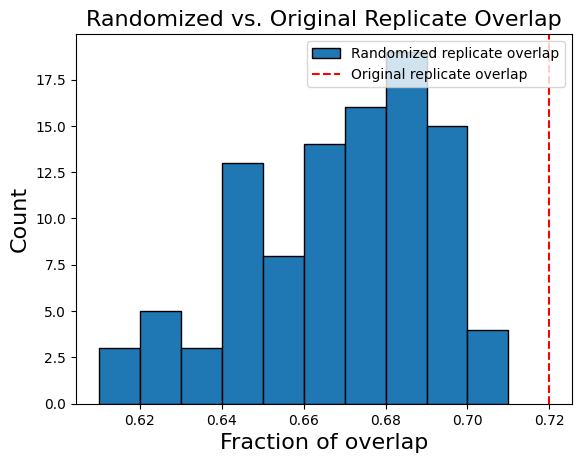

In [70]:
plt.hist(accuracy_list,edgecolor='black',rwidth=1,label="Randomized replicate overlap")
plt.axvline(original_accuracy,linestyle="--",color="red",label="Original replicate overlap")
plt.title("Randomized vs. Original Replicate Overlap",fontdict={'fontsize':16})
plt.legend(loc="upper right")
plt.xlabel("Fraction of overlap",fontsize=16)
plt.ylabel("Count",fontsize=16)


# Dataset 5: Spatial Cardiovascular Data (Figure 6 & 7)

## Find most common interacting cell groups and spatial adjacency across all fibrotic and ischemic slides (Fig 4 B-G)

In [78]:
fibrotic_list = []
for i in os.listdir("../../results/GraphComm_Output/Cardiac_cells/"):
    if "FZ" in i:
        temp_df = pd.read_csv(f"../../results/GraphComm_Output/Cardiac_cells/{i}/CCI.csv",index_col=0)
        fibrotic_list.append(temp_df)
fibrotic_CCI = pd.concat(fibrotic_list)

In [79]:
ischemic_list = []
for i in os.listdir("../../results/GraphComm_Output/Cardiac_cells/"):
    if "IZ" in i:
        temp_df = pd.read_csv(f"../../results/GraphComm_Output/Cardiac_cells/{i}/CCI.csv",index_col=0)
        ischemic_list.append(temp_df)
ischemic_CCI = pd.concat(ischemic_list)

## remove self-loops

In [80]:
fibrotic_list = [i[i["Src Cell"] != i["Dst Cell"]] for i in fibrotic_list]
ischemic_list = [j[j["Src Cell"] != j["Dst Cell"]] for j in ischemic_list]

## from each slide, retain the top 100 interactions

In [81]:
fibrotic_CCI = pd.concat(fibrotic_list)
ischemic_CCI = pd.concat(ischemic_list)

In [82]:
fibrotic_CCI = pd.concat([i.head(100) for i in fibrotic_list])
ischemic_CCI = pd.concat([i.head(100) for i in ischemic_list])

In [83]:
fibrotic_CCI = fibrotic_CCI.sort_values("Prob",ascending=False)
ischemic_CCI = ischemic_CCI.sort_values("Prob",ascending=False)

In [84]:
fibrotic_cell_groups = list(set(fibrotic_CCI["Src Cell"].unique().tolist() + fibrotic_CCI["Dst Cell"].unique().tolist()))
ischemic_cell_groups = list(set(ischemic_CCI["Src Cell"].unique().tolist() + ischemic_CCI["Dst Cell"].unique().tolist()))

In [85]:
fibrotic_matrix = pd.DataFrame(index=fibrotic_cell_groups,columns=fibrotic_cell_groups)
ischemic_matrix = pd.DataFrame(index=ischemic_cell_groups,columns=ischemic_cell_groups)

In [86]:
fibrotic_CCI = fibrotic_CCI[["Src Cell","Dst Cell","Prob"]]
ischemic_CCI = ischemic_CCI[["Src Cell","Dst Cell","Prob"]]

In [87]:
fibrotic_CCI = fibrotic_CCI.groupby(["Src Cell","Dst Cell"]).count()
ischemic_CCI = ischemic_CCI.groupby(["Src Cell","Dst Cell"]).count()

In [88]:
fibrotic_matrix = fibrotic_matrix.fillna(0)
ischemic_matrix = ischemic_matrix.fillna(0)

In [89]:
for index,row in fibrotic_CCI.iterrows():
    fibrotic_matrix.loc[index[0],index[1]] += row["Prob"]
    fibrotic_matrix.loc[index[1],index[0]] += row["Prob"]

In [90]:
for index,row in ischemic_CCI.iterrows():
    ischemic_matrix.loc[index[0],index[1]] += row["Prob"]
    ischemic_matrix.loc[index[1],index[0]] += row["Prob"]

In [91]:
fibrotic_matrix = fibrotic_matrix.fillna(0)
ischemic_matrix = ischemic_matrix.fillna(0)

In [92]:
import numpy as np

In [93]:
import seaborn as sns

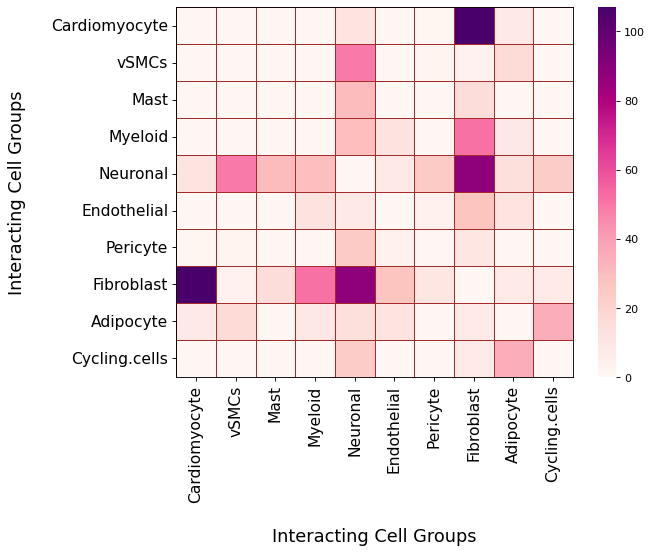

In [94]:
%matplotlib inline
figure(figsize=(8, 6), dpi=80)
ax = sns.heatmap(fibrotic_matrix,cmap="RdPu",linewidths=0.5, linecolor='brown')
ax.set_xlabel("\nInteracting Cell Groups",fontdict={'fontsize':16})
ax.set_ylabel("Interacting Cell Groups\n",fontdict={'fontsize':16})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
for _, spine in ax.spines.items():
    spine.set_visible(True)

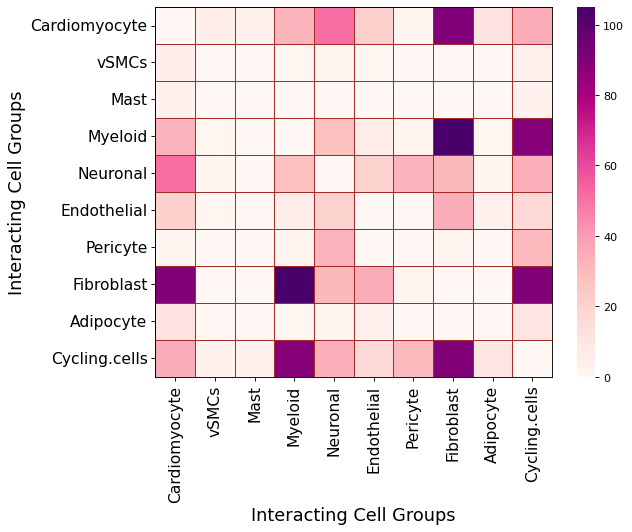

In [95]:
%matplotlib inline
figure(figsize=(8, 6), dpi=80)

ax = sns.heatmap(ischemic_matrix,cmap="RdPu",linewidths=0.5, linecolor='brown')
ax.set_xlabel("Interacting Cell Groups",fontdict={'fontsize':16})
ax.set_ylabel("Interacting Cell Groups",fontdict={'fontsize':16})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
for _, spine in ax.spines.items():
    spine.set_visible(True)

# Comparison of spatial adjacency in a given fibrotic slide (visualize abundant/scarce cell group interaction spatially)

## Example visualization of abundant interaction

In [96]:
adata = sc.read_h5ad("../../data/raw_data/Cardiac_cells/Visium-FZ_GT_P19.h5ad")
original_meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})

In [97]:
groups = ["Fibroblast","Cardiomyocyte"]
colour_dict = {groups[0]:"red",groups[1]:"blue"}

In [98]:
unique_cells = adata.obs[adata.obs['cell_type_original'].isin(groups)].index.tolist()
unique_cells = list(set(unique_cells))
meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})
adata = adata[unique_cells]
meta.index = meta["cell"].tolist()

In [99]:
sc.set_figure_params(scanpy=True, fontsize=20,figsize=(7,7))

/opt/conda/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


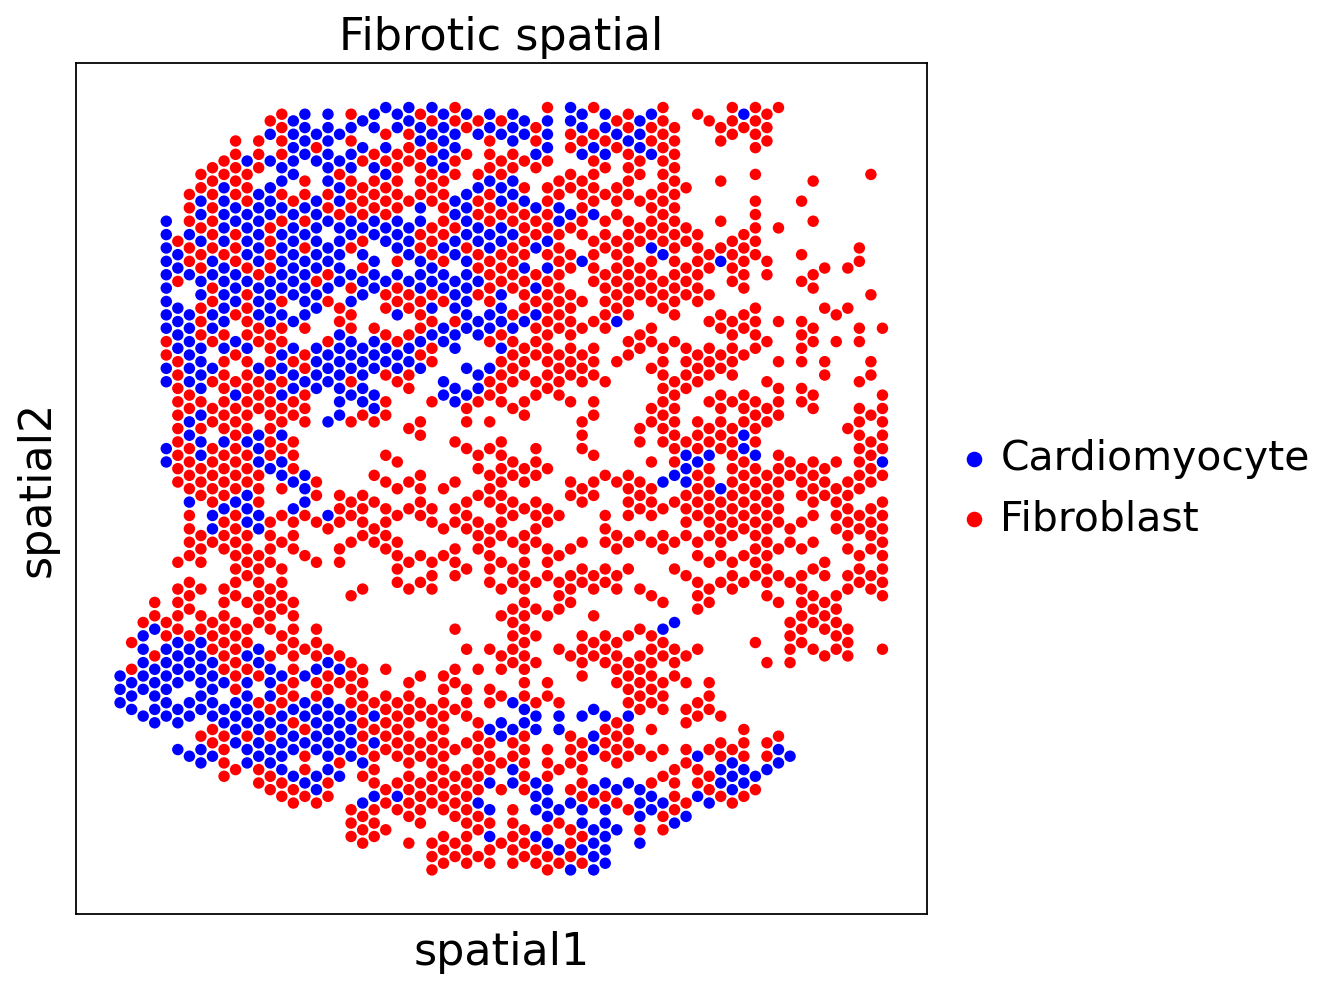

In [100]:
sc.pl.spatial(adata,img_key=None,spot_size=0.015,color="cell_type_original",palette=colour_dict,title="Fibrotic spatial")

In [101]:
import math

In [207]:
adata = sc.read_h5ad("../../data/raw_data/Cardiac_cells/Visium-FZ_GT_P19.h5ad")
original_meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})

In [208]:
groups = ["Fibroblast","Cardiomyocyte"]
colour_dict = {groups[0]:"red",groups[1]:"blue"}

In [209]:
unique_cells = adata.obs[adata.obs['cell_type_original'].isin(groups)].index.tolist()
unique_cells = list(set(unique_cells))
meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})
adata = adata[unique_cells]
adata.obs["barcode"] = adata.obs.index.tolist()
adata.obs["barcode"] = adata.obs["barcode"].astype('category')

<ipython-input-209-9e23e81246f9>:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["barcode"] = adata.obs.index.tolist()


In [210]:
new_meta = meta[(meta["labels"]==groups[0]) | (meta["labels"]==groups[1])]

In [211]:
spatial_coordinates = adata.obsm["X_spatial"]
spatial_df = pd.DataFrame({"x":spatial_coordinates[:,0],"y":spatial_coordinates[:,1]},index=new_meta.index.tolist())

In [212]:
total_list = []
data_list = []
one = "Fibroblast"
two = "Cardiomyocyte"
cells = new_meta[new_meta["labels"]==one].index.tolist()
spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[cells]["x"].tolist(),spatial_df.loc[cells]["y"].tolist())]
#if two != one:
second_cells = new_meta[new_meta["labels"]==two].index.tolist()
second_spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[second_cells]["x"].tolist(),spatial_df.loc[second_cells]["y"].tolist())]
min_list = []
for k in spatial_coords:
    min_list.append(np.min([math.dist(k,l) for l in second_spatial_coords]))
data_list.append(np.mean(min_list))


In [213]:
data_list

[0.021398797407116255]

## identify validated ligand-receptor pairs that occur in abundant cell group interaction

In [214]:
fibrotic_ints = pd.concat(fibrotic_list)

In [215]:
one="Fibroblast"
two="Endothelial"

In [216]:
fibrotic_ints = fibrotic_ints[((fibrotic_ints["Src Cell"]==one)&(fibrotic_ints["Dst Cell"]==two)) | ((fibrotic_ints["Dst Cell"]==one)&(fibrotic_ints["Src Cell"]==two))]

In [217]:
consensus = pd.read_csv("../../data/LR_database/intercell_Omnipath.csv",index_col=0)

In [218]:
fibrotic_ints = pd.merge(fibrotic_ints,consensus,left_on=["Src","Dst"],right_on=["source_genesymbol","target_genesymbol"])

## Example visualization of scarce interaction

In [219]:
adata = sc.read_h5ad("../../data/raw_data/Cardiac_cells/Visium-FZ_P14.h5ad")
original_meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})

In [220]:
groups = ["Cycling.cells","Mast"]
colour_dict = {groups[0]:"red",groups[1]:"blue"}

In [221]:
unique_cells = adata.obs[adata.obs['cell_type_original'].isin(groups)].index.tolist()
unique_cells = list(set(unique_cells))
meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})
adata = adata[unique_cells]
meta.index = meta["cell"].tolist()

/opt/conda/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


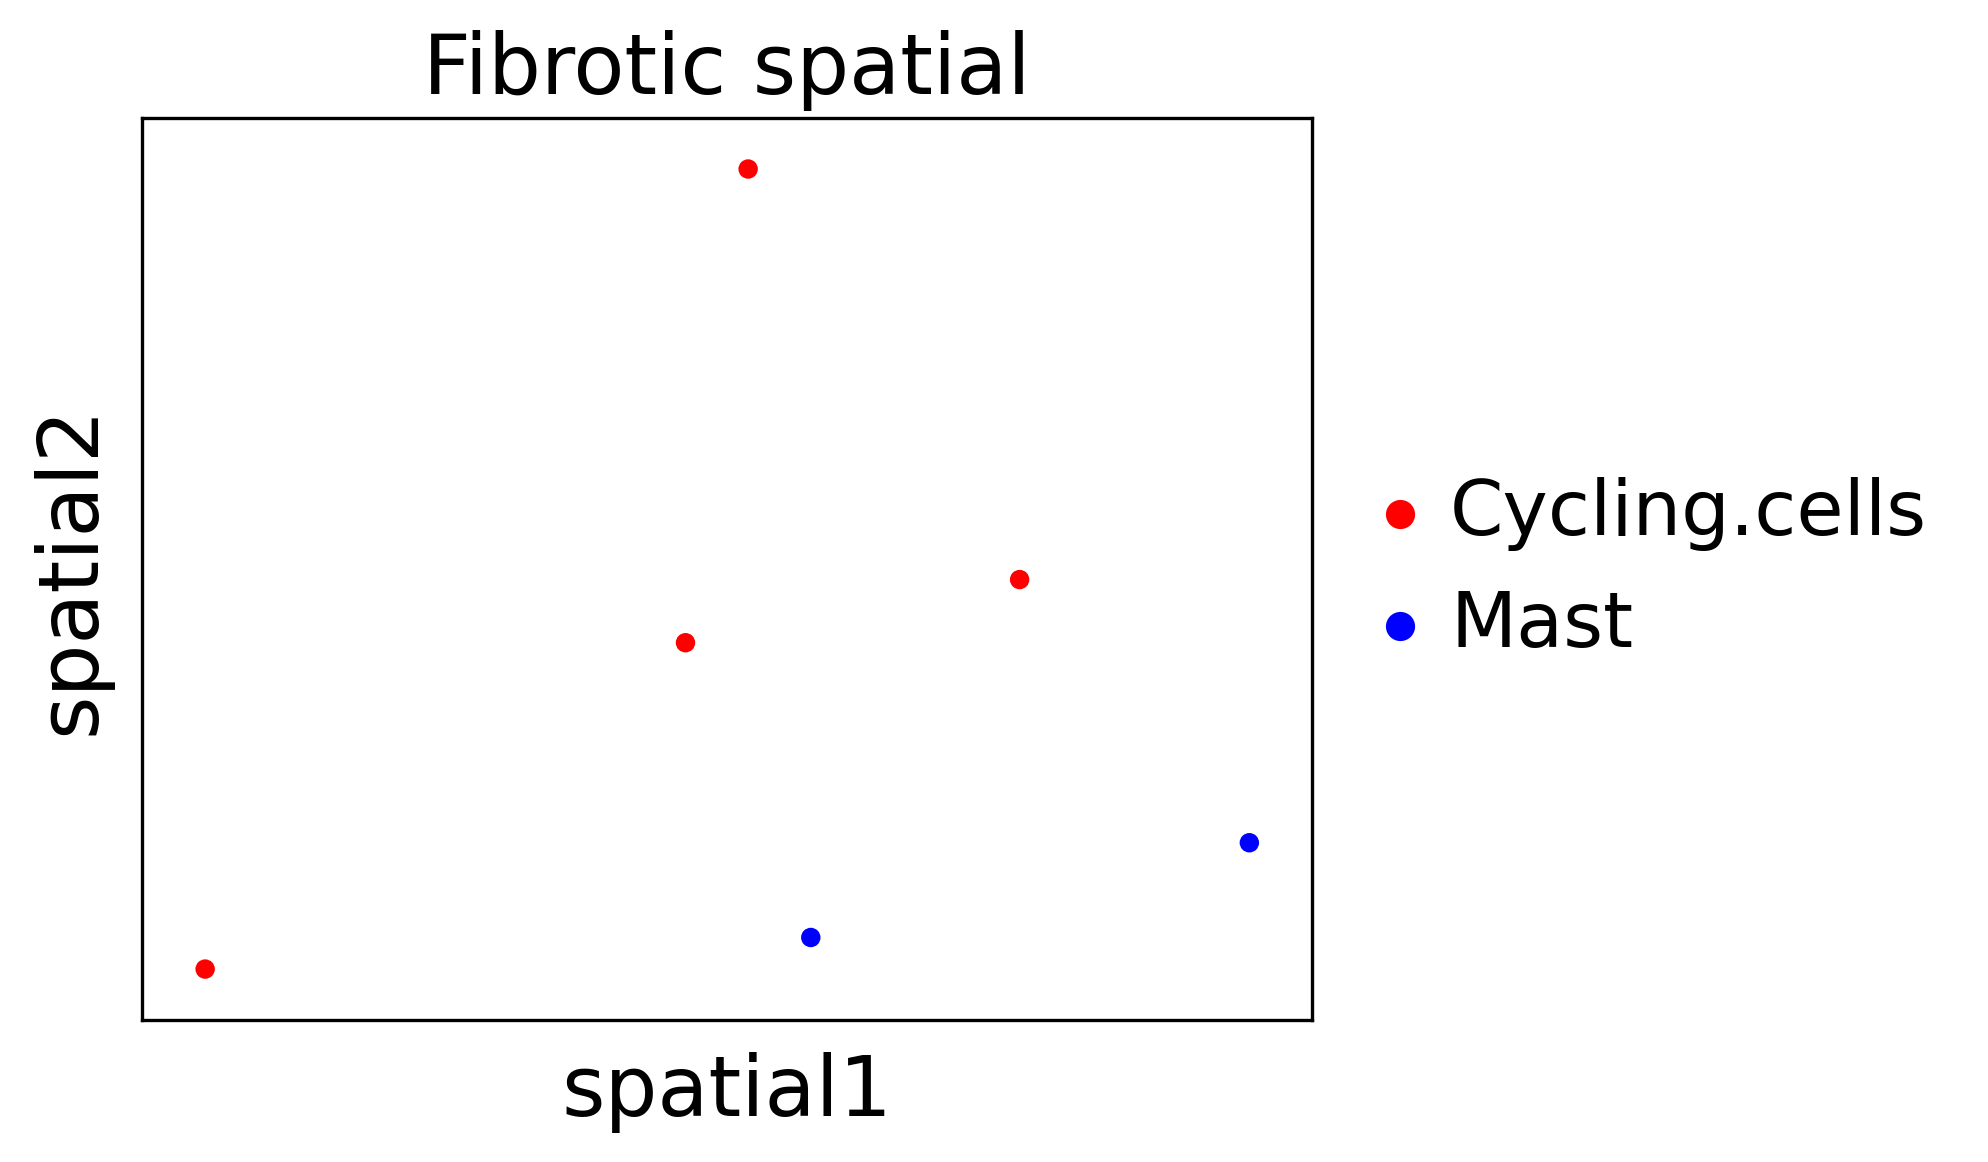

In [222]:
%matplotlib inline
with plt.rc_context({"figure.figsize": (5, 5), "figure.dpi": (150)}):
    sc.pl.spatial(adata,img_key=None,spot_size=0.015,color="cell_type_original",title="Fibrotic spatial",palette=colour_dict)

In [223]:
import math

In [224]:
adata = sc.read_h5ad("../../data/raw_data/Cardiac_cells/Visium-FZ_P14.h5ad")
original_meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})

In [225]:
groups = ["Cycling.cells","Mast"]
colour_dict = {groups[0]:"red",groups[1]:"blue"}

In [226]:
unique_cells = adata.obs[adata.obs['cell_type_original'].isin(groups)].index.tolist()
unique_cells = list(set(unique_cells))
meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})
adata = adata[unique_cells]
adata.obs["barcode"] = adata.obs.index.tolist()
adata.obs["barcode"] = adata.obs["barcode"].astype('category')

<ipython-input-226-9e23e81246f9>:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["barcode"] = adata.obs.index.tolist()


In [227]:
new_meta = meta[(meta["labels"]==groups[0]) | (meta["labels"]==groups[1])]

In [228]:
spatial_coordinates = adata.obsm["X_spatial"]
spatial_df = pd.DataFrame({"x":spatial_coordinates[:,0],"y":spatial_coordinates[:,1]},index=new_meta.index.tolist())

In [229]:
total_list = []
data_list = []
one = groups[0]
two = groups[1]
cells = new_meta[new_meta["labels"]==one].index.tolist()
spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[cells]["x"].tolist(),spatial_df.loc[cells]["y"].tolist())]
#if two != one:
second_cells = new_meta[new_meta["labels"]==two].index.tolist()
second_spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[second_cells]["x"].tolist(),spatial_df.loc[second_cells]["y"].tolist())]
min_list = []
for k in spatial_coords:
    min_list.append(np.min([math.dist(k,l) for l in second_spatial_coords]))
data_list.append(np.mean(min_list))


In [230]:
data_list

[0.4665179210283076]

# Comparison of spatial adjacency in a given ischemic slide (visualize abundant/scarce cell group interaction spatially)

## Example visualization of abundant interaction

In [231]:
adata = sc.read_h5ad("../../data/raw_data/Cardiac_cells/Visium-IZ_P10.h5ad")
original_meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})

In [232]:
groups = ["Fibroblast","Myeloid"]
colour_dict = {groups[0]:"red",groups[1]:"blue"}

In [233]:
unique_cells = adata.obs[adata.obs['cell_type_original'].isin(groups)].index.tolist()
unique_cells = list(set(unique_cells))
meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})
adata = adata[unique_cells]

/opt/conda/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


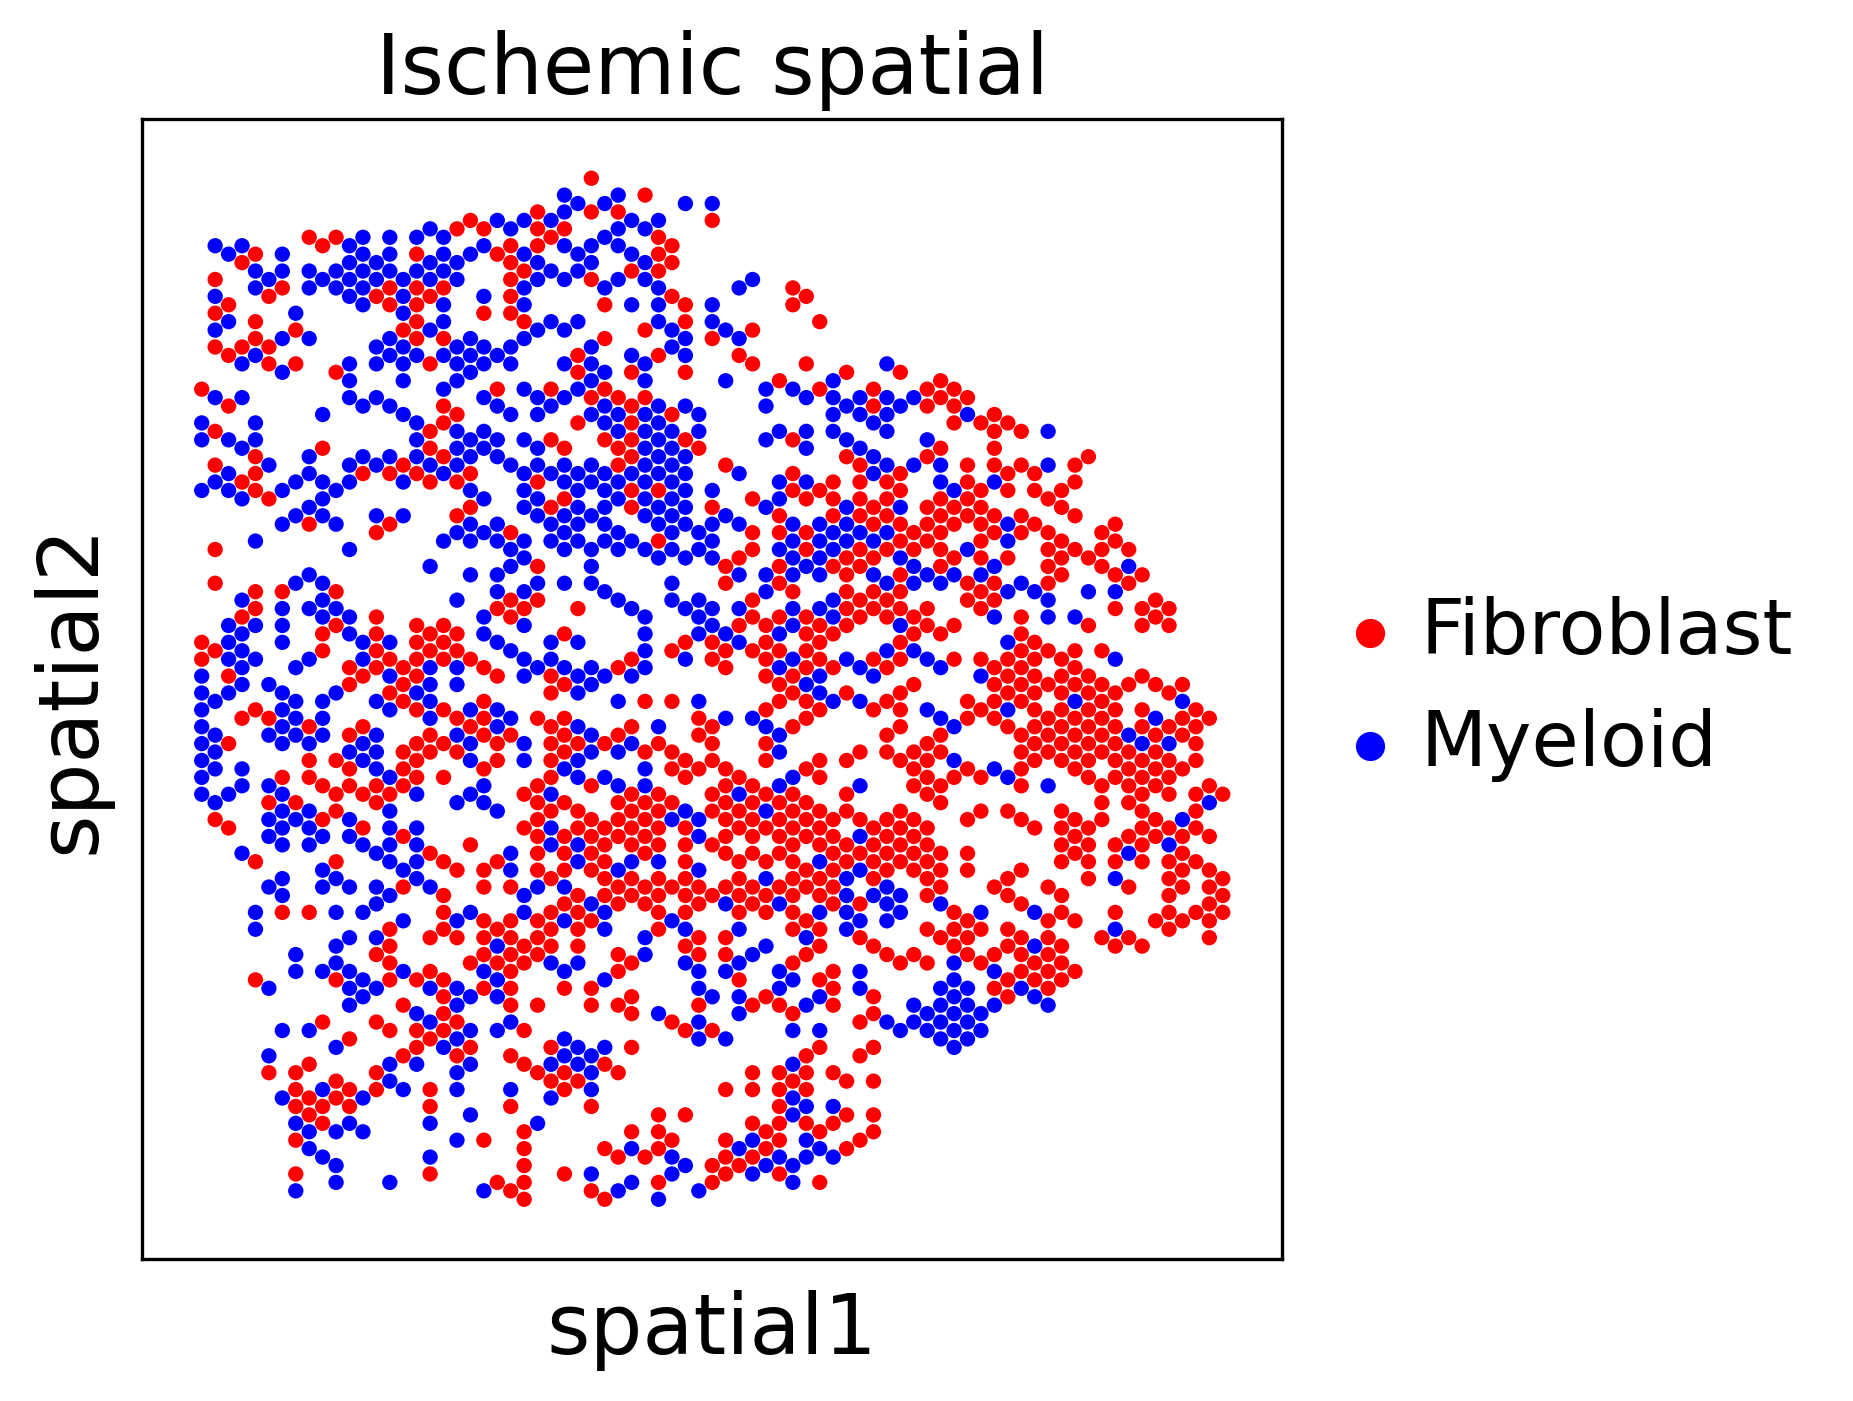

In [234]:
%matplotlib inline
with plt.rc_context({"figure.figsize": (5, 5), "figure.dpi": (150)}):
    sc.pl.spatial(adata,img_key=None,spot_size=0.015,color="cell_type_original",color_map="viridis",title="Ischemic spatial",palette=colour_dict)

In [235]:
import math

In [236]:
adata = sc.read_h5ad("../../data/raw_data/Cardiac_cells/Visium-IZ_P10.h5ad")
original_meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})

In [237]:
groups = ["Fibroblast","Myeloid"]
colour_dict = {groups[0]:"red",groups[1]:"blue"}

In [238]:
unique_cells = adata.obs[adata.obs['cell_type_original'].isin(groups)].index.tolist()
unique_cells = list(set(unique_cells))
meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})
adata = adata[unique_cells]
adata.obs["barcode"] = adata.obs.index.tolist()
adata.obs["barcode"] = adata.obs["barcode"].astype('category')

<ipython-input-238-9e23e81246f9>:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["barcode"] = adata.obs.index.tolist()


In [239]:
new_meta = meta[(meta["labels"]==groups[0]) | (meta["labels"]==groups[1])]

In [240]:
spatial_coordinates = adata.obsm["X_spatial"]
spatial_df = pd.DataFrame({"x":spatial_coordinates[:,0],"y":spatial_coordinates[:,1]},index=new_meta.index.tolist())

In [241]:
total_list = []
data_list = []
one = groups[0]
two = groups[1]
cells = new_meta[new_meta["labels"]==one].index.tolist()
spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[cells]["x"].tolist(),spatial_df.loc[cells]["y"].tolist())]
#if two != one:
second_cells = new_meta[new_meta["labels"]==two].index.tolist()
second_spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[second_cells]["x"].tolist(),spatial_df.loc[second_cells]["y"].tolist())]
min_list = []
for k in spatial_coords:
    min_list.append(np.min([math.dist(k,l) for l in second_spatial_coords]))
data_list.append(np.mean(min_list))


In [245]:
data_list

[0.01836631840452934]

## Example visualization of scarce interaction

In [246]:
adata = sc.read_h5ad("../../data/raw_data/Cardiac_cells/Visium-IZ_BZ_P2.h5ad")
original_meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})

In [247]:
groups = ["Adipocyte","Mast"]
colour_dict = {groups[0]:"red",groups[1]:"blue"}

In [248]:
unique_cells = adata.obs[adata.obs['cell_type_original'].isin(groups)].index.tolist()
unique_cells = list(set(unique_cells))
meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})
adata = adata[unique_cells]
meta.index = meta["cell"].tolist()

/opt/conda/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


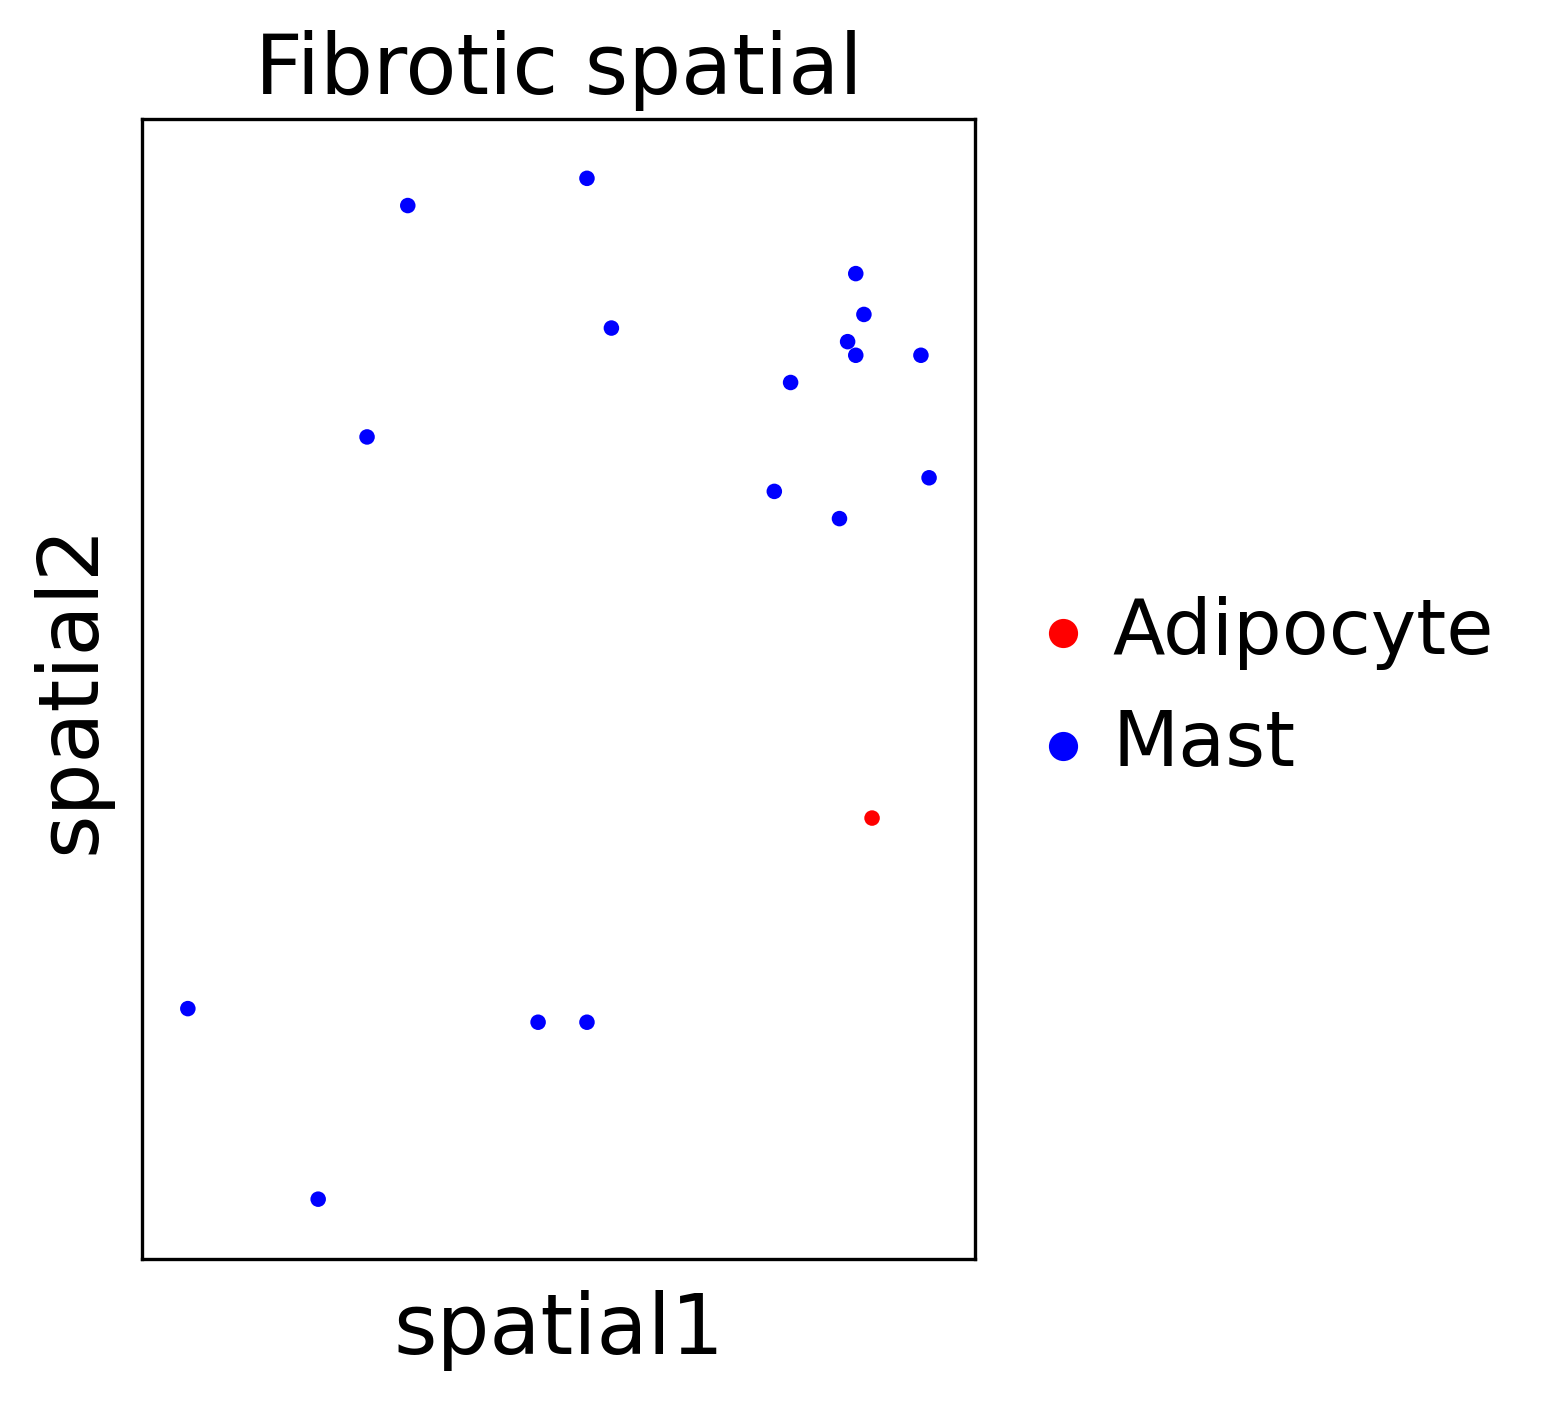

In [249]:
%matplotlib inline
with plt.rc_context({"figure.figsize": (5, 5), "figure.dpi": (150)}):
    sc.pl.spatial(adata,img_key=None,spot_size=0.015,color="cell_type_original",title="Fibrotic spatial",palette=colour_dict)

In [250]:
import math

In [251]:
adata = sc.read_h5ad("../../data/raw_data/Cardiac_cells/Visium-IZ_BZ_P2.h5ad")
original_meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})

In [252]:
groups = ["Adipocyte","Mast"]
colour_dict = {groups[0]:"red",groups[1]:"blue"}

In [253]:
unique_cells = adata.obs[adata.obs['cell_type_original'].isin(groups)].index.tolist()
unique_cells = list(set(unique_cells))
meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})
adata = adata[unique_cells]
adata.obs["barcode"] = adata.obs.index.tolist()
adata.obs["barcode"] = adata.obs["barcode"].astype('category')

<ipython-input-253-9e23e81246f9>:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["barcode"] = adata.obs.index.tolist()


In [254]:
new_meta = meta[(meta["labels"]==groups[0]) | (meta["labels"]==groups[1])]

In [255]:
spatial_coordinates = adata.obsm["X_spatial"]
spatial_df = pd.DataFrame({"x":spatial_coordinates[:,0],"y":spatial_coordinates[:,1]},index=new_meta.index.tolist())

In [256]:
total_list = []
data_list = []
one = groups[0]
two = groups[1]
cells = new_meta[new_meta["labels"]==one].index.tolist()
spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[cells]["x"].tolist(),spatial_df.loc[cells]["y"].tolist())]
#if two != one:
second_cells = new_meta[new_meta["labels"]==two].index.tolist()
second_spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[second_cells]["x"].tolist(),spatial_df.loc[second_cells]["y"].tolist())]
min_list = []
for k in spatial_coords:
    min_list.append(np.min([math.dist(k,l) for l in second_spatial_coords]))
data_list.append(np.mean(min_list))


In [257]:
data_list

[0.06826806509371086]

## identify validated ligand-receptor pairs that occur in abundant cell group interaction

In [258]:
ischemic_ints = pd.concat(ischemic_list)

In [259]:
one="vSMCs"
two="Endothelial"

In [260]:
ischemic_ints = ischemic_ints[((ischemic_ints["Src Cell"]==one)&(ischemic_ints["Dst Cell"]==two)) | ((ischemic_ints["Dst Cell"]==one)&(ischemic_ints["Src Cell"]==two))]

In [261]:
consensus = pd.read_csv("/data/LR_database/intercell_Omnipath.csv",index_col=0)

In [262]:
ischemic_ints = pd.merge(ischemic_ints,consensus,left_on=["Src","Dst"],right_on=["source_genesymbol","target_genesymbol"])

# Analysis of single slide *FZ_GT_P19*

### visualize the total spatial map of tissue

In [263]:
input_data = pd.read_csv("../../results/GraphComm_Output/Cardiac_cells/FZ_GT_P19/CCI.csv",index_col=0)
input_data.index = range(0,input_data.shape[0])

In [264]:
adata = sc.read_h5ad("../../data/raw_data/Cardiac_cells/Visium-FZ_GT_P19.h5ad")
original_meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})

### subset for **only validated intercell interactions**, and remove any self loops

In [265]:
#input_data = input_data[input_data["Src Cell"] != input_data["Dst Cell"]]
unique_groups = input_data.drop_duplicates(["Src Cell","Dst Cell"])

In [266]:
intercell_network = pd.read_csv("../../data/LR_database/intercell_Omnipath.csv",index_col=0)

In [267]:
intercell_network.columns = ["source_genesymbol","target_genesymbol","refs"]

## generate table for Cytoscape network

### list top ranked or low ranked interactions

## identify patterns in cell group interactions in only validated LR pairs

In [268]:
top_input = input_data.head(1000)

In [269]:
top_input = top_input.groupby(["Src Cell","Dst Cell"]).sum("Prob")

In [271]:
top_input.sort_values("Prob")

Prob
Src Cell      Dst Cell                 
Neuronal      Fibroblast       0.795341
Cardiomyocyte Myeloid          0.800741
Pericyte      Fibroblast       1.489921
vSMCs         Myeloid          1.601482
Neuronal      Endothelial      2.385164
              Mast             3.976116
Pericyte      Endothelial      4.468155
              Mast             5.959415
Endothelial   Pericyte         6.700670
              Neuronal         6.798996
Pericyte      Myeloid         10.550818
Myeloid       Pericyte        11.015375
Fibroblast    Pericyte        11.016430
Myeloid       Neuronal        11.177015
Fibroblast    Neuronal        11.178085
Neuronal      Myeloid         12.764625
Mast          Pericyte        15.250535
              Neuronal        15.474321
Pericyte      Cardiomyocyte   17.874446
Neuronal      Cardiomyocyte   19.079449
              vSMCs           21.395296
Cardiomyocyte Pericyte        23.636278
              Neuronal        25.549295
Pericyte      vSMCs           34.257387
vSMCs         Pericyte        69.263565
              Neuronal        73.412295
Neuronal      Pericyte        89.226397
              Neuronal        93.599939
Pericyte      Neuronal       105.120651
              Pericyte       119.855642

In [272]:
import networkx as nx

In [273]:
edges = top_input.index.tolist()

In [274]:
graph = nx.Graph()

In [275]:
for i,j in zip(edges, top_input["Prob"].tolist()):
    graph.add_edge(i[0],i[1],weight=j)

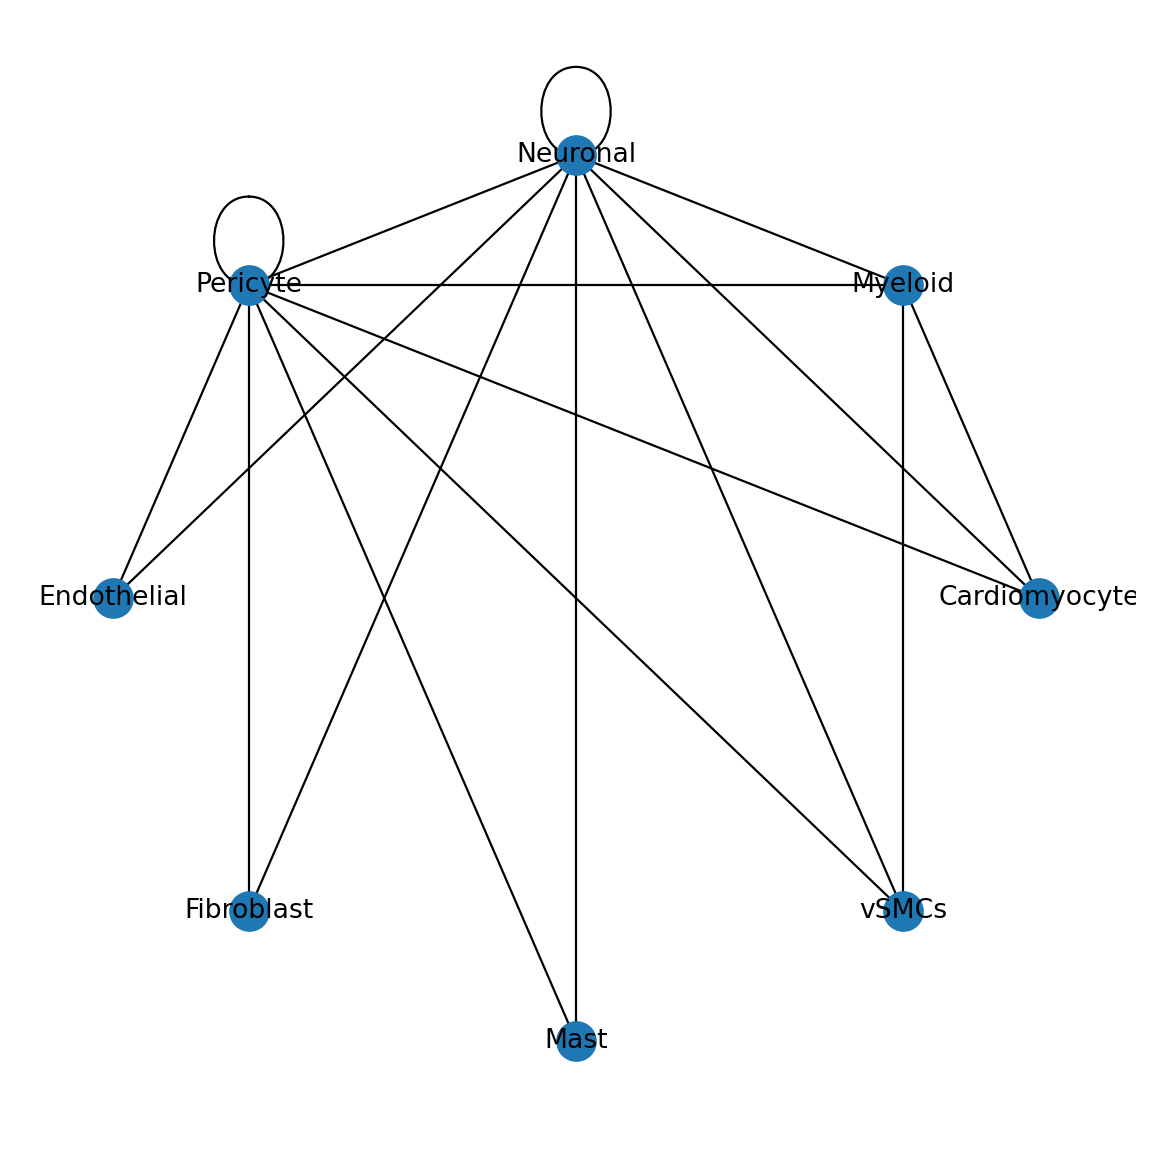

In [276]:
pos = nx.circular_layout(graph)
nx.draw(graph,pos,with_labels=True)

In [277]:
top_input = top_input.sort_values("Prob",ascending=False)

In [ ]:
os.system("mkdir -p /results/GraphComm_Output/Cardiac_cells/")

In [278]:
top_input.to_csv("/results/GraphComm_Output/Cardiac_cells//FZ_GT_P19_grouped.csv")

## Visualize top ranked interaction

In [280]:
input_data = pd.merge(input_data,intercell_network,left_on=["Src","Dst"],right_on=["source_genesymbol","target_genesymbol"])

In [281]:
input_data.head(20)

,Src,Dst,Prob,Src Cell,Dst Cell,source_genesymbol,target_genesymbol,refs
0,HLA-DRA,LGMN,0.683345,Myeloid,Neuronal,HLA-DRA,LGMN,Macrophage:14966190
1,HLA-DPA1,LGMN,0.683313,Myeloid,Neuronal,HLA-DPA1,LGMN,Macrophage:14966190
2,HLA-A,APLP2,0.683310,vSMCs,Neuronal,HLA-A,APLP2,CellTalkDB:19184004;Cellinker:19184004;HPRD:19...
3,MMRN2,CD93,0.683287,Pericyte,Pericyte,MMRN2,CD93,connectomeDB2020:28671670
4,HLA-DPB1,LGMN,0.584277,Myeloid,Neuronal,HLA-DPB1,LGMN,Macrophage:14966190
5,HLA-DRA,CD37,0.584241,Myeloid,Neuronal,HLA-DRA,CD37,Cellinker:8119731
6,HLA-DMA,LGMN,0.584120,Myeloid,Neuronal,HLA-DMA,LGMN,Macrophage:14966190
7,HLA-DQB1,LGMN,0.584013,Neuronal,Neuronal,HLA-DQB1,LGMN,Macrophage:14966190
8,MMRN2,CD248,0.557188,Pericyte,Neuronal,MMRN2,CD248,connectomeDB2020:28671670
9,CXCL2,CXCR1,0.521536,Pericyte,Pericyte,CXCL2,CXCR1,Baccin2019:12964882;Baccin2019:1379593;Baccin2...


In [282]:
input_data.head(1000).groupby("Dst").count().sort_values("Prob",ascending=True)

,Src,Prob,Src Cell,Dst Cell,source_genesymbol,target_genesymbol,refs
Dst,,,,,,,
ABCB1,1,1,1,1,1,1,1
NPTXR,1,1,1,1,1,1,1
NOS3,1,1,1,1,1,1,1
NCAM2,1,1,1,1,1,1,1
NAALAD2,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...
LGMN,9,9,9,9,9,9,9
CTSF,9,9,9,9,9,9,9
DPP4,10,10,10,10,10,10,10


In [283]:
adata = sc.read_h5ad("../../data/raw_data/Cardiac_cells/Visium-FZ_GT_P19.h5ad")
original_meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})

In [ ]:
groups = ["Myeloid","Pericyte"]
colour_dict = {groups[0]:"red",groups[1]:"blue"}

In [ ]:
unique_cells = adata.obs[adata.obs['cell_type_original'].isin(groups)].index.tolist()
unique_cells = list(set(unique_cells))
meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})
adata = adata[unique_cells]
adata.obs["barcode"] = adata.obs.index.tolist()
adata.obs["barcode"] = adata.obs["barcode"].astype('category')

<ipython-input-285-9e23e81246f9>:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["barcode"] = adata.obs.index.tolist()


In [ ]:
sc.set_figure_params(scanpy=True, fontsize=20,figsize=(7,7))

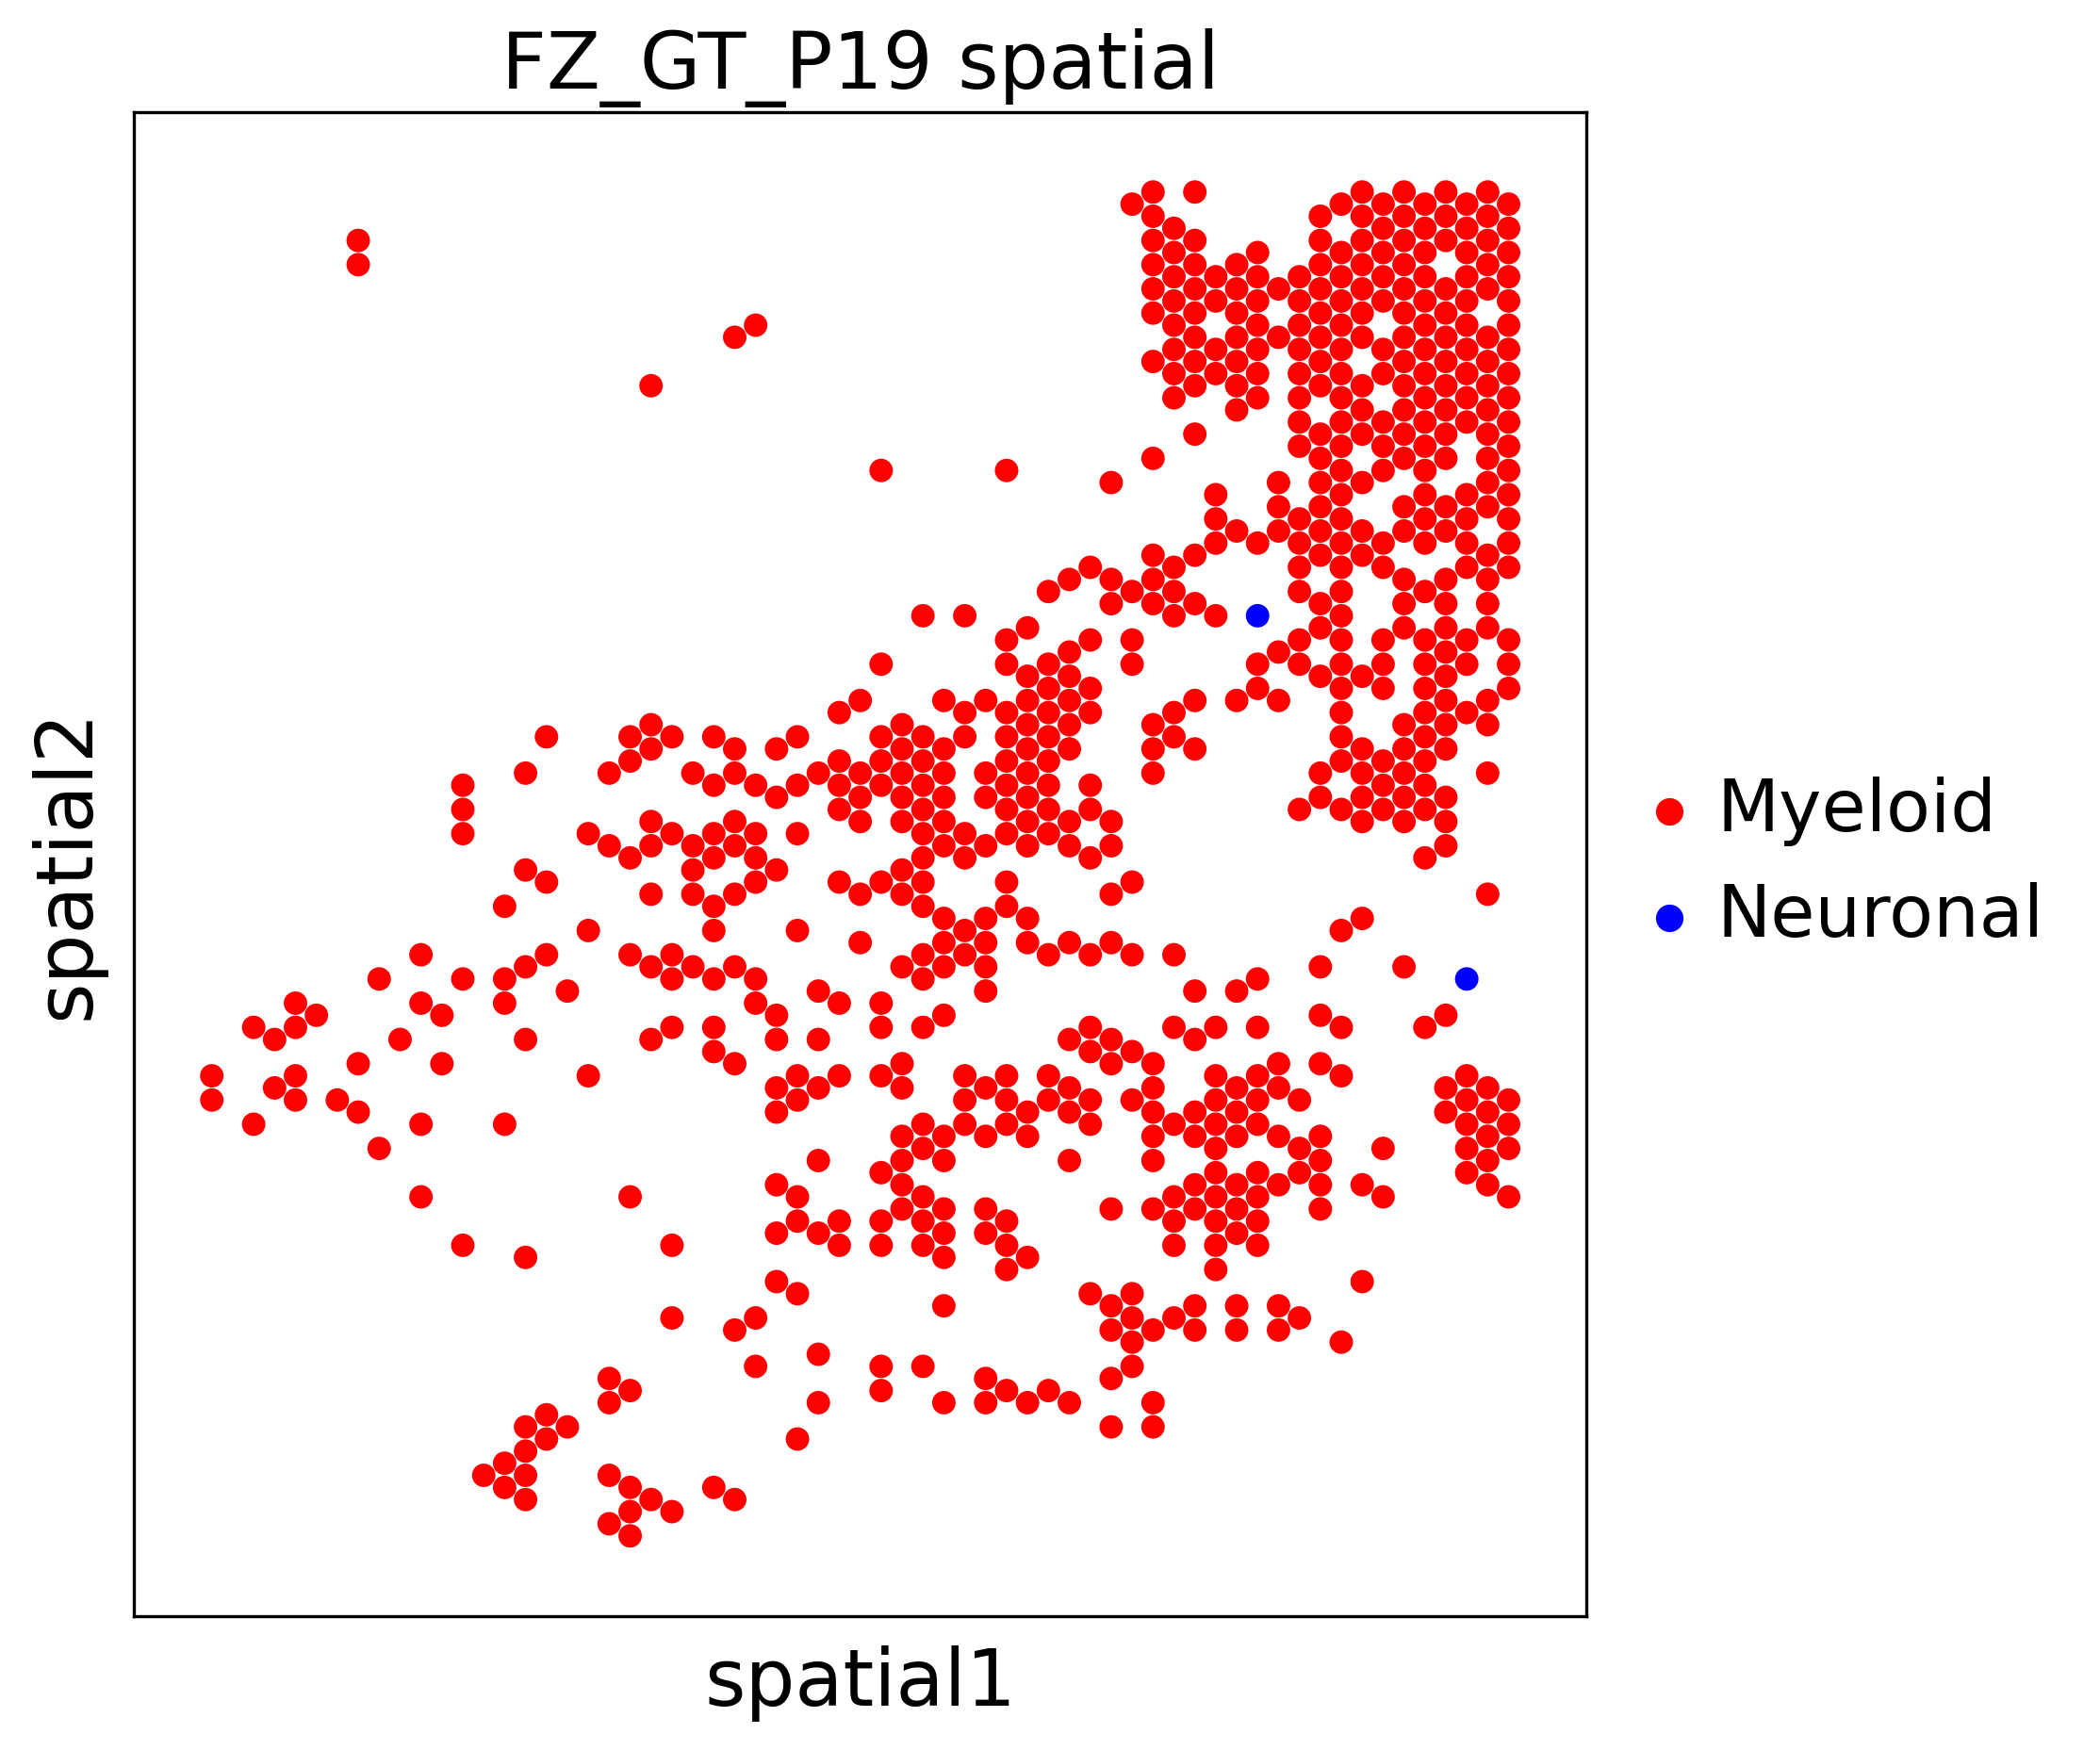

In [ ]:
%matplotlib inline
with plt.rc_context({"figure.figsize": (7, 7), "figure.dpi": (150)}):
    sc.pl.spatial(adata,img_key=None,spot_size=0.017,scale_factor=1,color="cell_type_original",title="FZ_GT_P19 spatial",palette=colour_dict)

In [295]:
new_meta = meta[(meta["labels"]=="Neuronal") | (meta["labels"]=="Myeloid")]

In [296]:
spatial_coordinates = adata.obsm["X_spatial"]
spatial_df = pd.DataFrame({"x":spatial_coordinates[:,0],"y":spatial_coordinates[:,1]},index=new_meta.index.tolist())

In [297]:
relevant_input = input_data[((input_data["Src Cell"]==one)&(input_data["Dst Cell"]==two)) | ((input_data["Dst Cell"]==one)&(input_data["Src Cell"]==two))]






## calculate mean eucledian distance between all spots of cell groups

In [298]:
import math

In [300]:
total_list = []
data_list = []
one = "Neuronal"
two = "Myeloid"
cells = new_meta[new_meta["labels"]==one].index.tolist()
spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[cells]["x"].tolist(),spatial_df.loc[cells]["y"].tolist())]
#if two != one:
second_cells = new_meta[new_meta["labels"]==two].index.tolist()
second_spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[second_cells]["x"].tolist(),spatial_df.loc[second_cells]["y"].tolist())]
min_list = []
for k in spatial_coords:
    min_list.append(np.min([math.dist(k,l) for l in second_spatial_coords]))
data_list.append(np.mean(min_list))


In [301]:
data_list

[0.017507574481738557]

## Visualize low-ranked interaction

In [302]:
adata = sc.read_h5ad("../../data/raw_data/Cardiac_cells/Visium-FZ_GT_P19.h5ad")
original_meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})

In [303]:
groups = ["vSMCs","Mast"]
colour_dict = {groups[0]:"red",groups[1]:"blue"}

In [304]:
unique_cells = adata.obs[adata.obs['cell_type_original'].isin(groups)].index.tolist()
unique_cells = list(set(unique_cells))
meta = pd.DataFrame({"cell":adata.obs.index.tolist(),"labels":adata.obs["cell_type_original"].tolist()})
adata = adata[unique_cells]
adata.obs["barcode"] = adata.obs.index.tolist()
adata.obs["barcode"] = adata.obs["barcode"].astype('category')

<ipython-input-304-9e23e81246f9>:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["barcode"] = adata.obs.index.tolist()


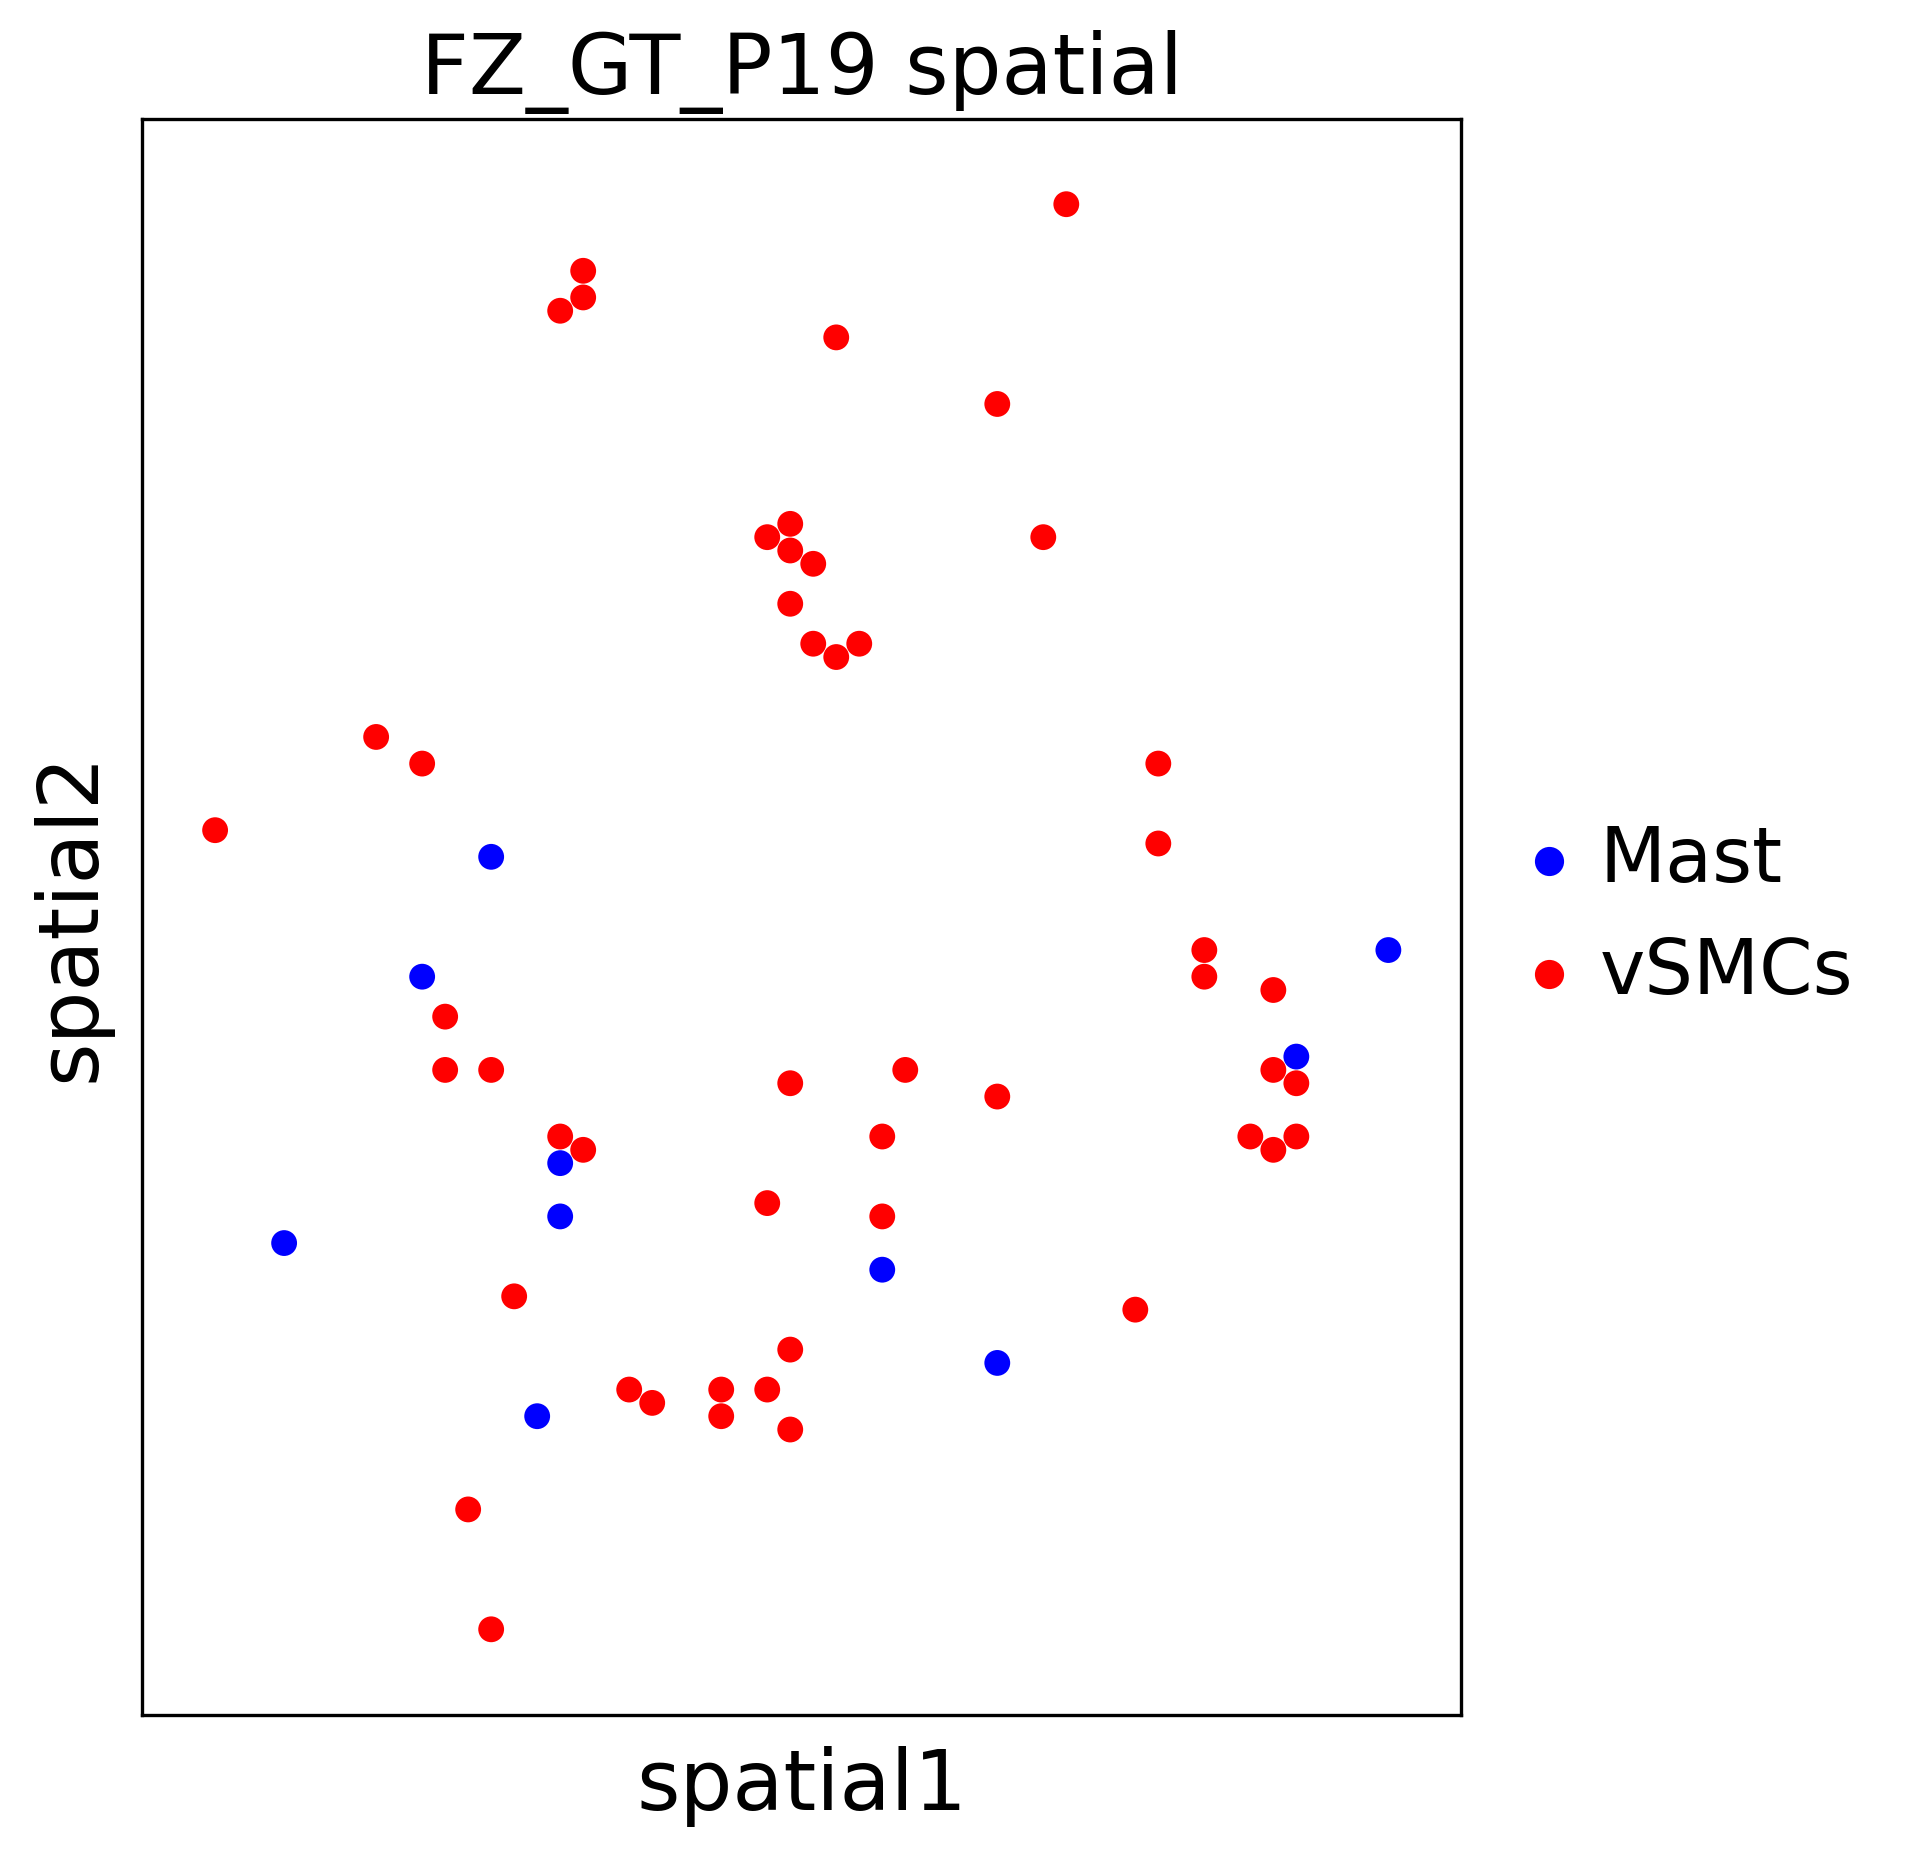

In [305]:
%matplotlib inline
with plt.rc_context({"figure.figsize": (7, 7), "figure.dpi": (150)}):
    sc.pl.spatial(adata,img_key=None,spot_size=0.017,scale_factor=1,color="cell_type_original",title="FZ_GT_P19 spatial",palette=colour_dict)

In [306]:
one = "vSMCs"
two = "Mast"

In [307]:
new_meta = meta[(meta["labels"]==one) | (meta["labels"]==two)]

In [308]:
spatial_coordinates = adata.obsm["X_spatial"]
spatial_df = pd.DataFrame({"x":spatial_coordinates[:,0],"y":spatial_coordinates[:,1]},index=new_meta.index.tolist())

In [309]:
import math

In [310]:
total_list = []
data_list = []
cells = new_meta[new_meta["labels"]==one].index.tolist()
spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[cells]["x"].tolist(),spatial_df.loc[cells]["y"].tolist())]
#if two != one:
second_cells = new_meta[new_meta["labels"]==two].index.tolist()
second_spatial_coords = [(i,j) for i,j in zip(spatial_df.loc[second_cells]["x"].tolist(),spatial_df.loc[second_cells]["y"].tolist())]
min_list = []
for k in spatial_coords:
    min_list.append(np.min([math.dist(k,l) for l in second_spatial_coords]))
data_list.append(np.mean(min_list))
total_list.append(data_list)


In [311]:
data_list

[0.13255865826428376]